In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Path Management

In [2]:
path = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\data\PXFront"
spx_path  = os.path.join(path, "ES.parquet")

# Make Signature Plot

In [3]:
def prep_data(path: str) -> pd.DataFrame:

    df_out = (pd.read_parquet(
        path = path, engine = "pyarrow").
        assign(date = lambda x: pd.to_datetime(x.date)).
        drop(columns = ["security"]).
        rename(columns = {"PX_LAST": "price"}).
        set_index("date"))
    
    return df_out

df_spx = prep_data(spx_path)

In [4]:
def get_all_data() -> pd.DataFrame:
    
    full_path = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\data\PXFront"
    paths = [os.path.join(full_path, path) for path in os.listdir(full_path) if path != "NG.parquet"]
    dfs = pd.concat([prep_data(path).assign(security = path.split("\\")[-1].split(".")[0]) for path in paths])
    
    return dfs

df_all = get_all_data()

In [5]:
def get_signature_plot(df: pd.DataFrame) -> pd.DataFrame: 
    
    rtns = df.pct_change().price.dropna()
    timesteps = [int(i + 1) for i in range(200)]
    stds = [
        (rtns.rolling(window = timestep).std().mean()) / rtns.std()
        for timestep in timesteps]

    df_signature = (pd.DataFrame({
        "timestep": timesteps,
        "stds": stds}).
        dropna().
        set_index("timestep"))
    
    return df_signature

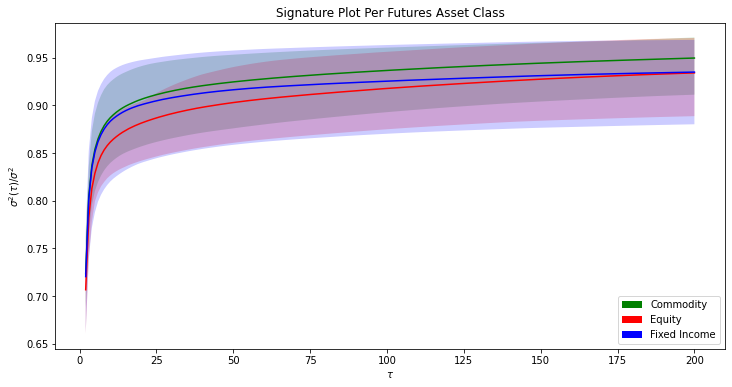

In [6]:
def make_singature_plot(df_all: pd.DataFrame) -> plt.Figure: 

    df_signature_plot = (df_all.groupby(
        "security").
        apply(get_signature_plot).
        reset_index())

    path = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\root\fut_tickers.xlsx"
    df_kind = (pd.read_excel(
        io = path, sheet_name = "px")
        [["contract", "kind"]].
        rename(columns = {"contract": "security"}))

    df_combined = (df_signature_plot.merge(
        right = df_kind, how = "inner",on = ["security"]))

    colors = {
        "Commodity": "Green",
        "Equity": "Red",
        "Fixed Income": "Blue"}

    legend_elements = [Patch(facecolor = colors[security_kind], label = security_kind) for security_kind in colors.keys()]
    fig, axes = plt.subplots(figsize = (12,6))
    for contract_kind in colors.keys():

        df_plot = (df_combined.query(
            "kind == @contract_kind").
            drop(columns = ["kind"]).
            pivot(index = "timestep", columns = "security", values = "stds"))

        df_minmax = (df_plot.reset_index().melt(
            id_vars = "timestep").
            drop(columns = ["security"]).
            groupby("timestep").
            agg(["min", "max"])
            ["value"])

        axes.fill_between(
            x = df_minmax.index,
            y1 = df_minmax["min"],
            y2 = df_minmax["max"],
            alpha = 0.2,
            facecolor = colors[contract_kind])

        df_plot.mean(axis = 1).plot(color = colors[contract_kind])

        axes.legend(handles = legend_elements, loc = "lower right")
        axes.set_xlabel(r"$\tau$")
        axes.set_ylabel(r"$\sigma^2(\tau)/\sigma^2$")
        axes.set_title("Signature Plot Per Futures Asset Class")
        
make_singature_plot(df_all)

# Prepping Time Series

We are going to normalize the returns of the strategy to make strategies unit variance. They use a method to get the EWMA of daily volatility. <br>
$$
\begin{equation}
\sigma_t := \gamma \sqrt{\mathcal{L}_{\tau_{\sigma}}[D_t^2]}
\end{equation}
$$
Then apply that to the Returns $R_t$
$$
\begin{equation}
R_t = \frac{D_t}{\sigma_{t-1}}
\end{equation}
$$
They authors set these parameters as $\gamma = 1.05$ and $\tau_{\sigma} = 10$.

In [11]:
def get_norm_rt(df: pd.DataFrame, tau: int = 10, gamma: float = 1.05) -> pd.DataFrame: 

    '''
    df_out = (df.assign(
        px_diff = lambda x: x.price.diff(),
        px_vol = lambda x: gamma * x.px_diff.ewm(span = tau, adjust = False).std(),
        rt = lambda x: x.px_diff / x.px_vol.shift()).
        dropna())
    '''
    df_out = (df.assign(
        px_diff = lambda x: x.price.diff(),
        px_vol = lambda x: gamma * (x.px_diff ** 2).ewm(span = tau, adjust = False).mean().apply(lambda y: np.sqrt(y)),
        rt = lambda x: x.px_diff / x.px_vol.shift()))
    
    return df_out

df_spx_rtn = get_norm_rt(df_spx)

# Simple Trend Model

First start by getting the EWMA of the retuns $\mathcal{L}_{\tau}[R_t]$

In [12]:
def approx_rtn(df: pd.DataFrame, tau: int = 180) -> pd.DataFrame:

    tau_ = (tau / 2) + (1 / (tau * 2))
    lambda_ = (0.01 / np.sqrt(tau))
    const = (lambda_ * tau) / (tau - 1)
    
    df_rtn_approx = (df.assign(
        signal = lambda x: np.sign(x.rt.ewm(span = tau, adjust = False).mean()).shift(),
        signal_rtn = lambda x: x.signal * x.rt,
        long_vol = lambda x: tau * (x.rt.ewm(span = tau, adjust = False).mean() ** 2),
        short_vol = lambda x: (x.rt ** 2).ewm(span = tau_, adjust = False).mean(),
        rhs_approx = lambda x: (const * (x.long_vol - x.short_vol)).cumsum(),
        lhs_approx = lambda x: x.signal_rtn.cumsum().ewm(span = tau_, adjust = False).mean()))
    
    return df_rtn_approx

df_rtn_approx = approx_rtn(df_spx_rtn)

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>]],
      dtype=object)

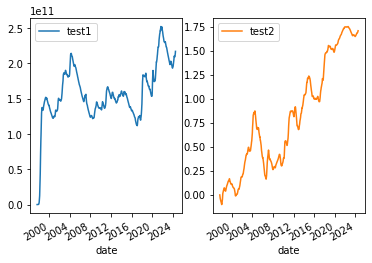

In [64]:
tau = 180
tau_ = tau / 2
lambda_ = 0.01 / np.sqrt(tau)

(df_spx_rtn.dropna().assign(
    signal_rtn = lambda x: (np.sign(x.rt.ewm(span = tau, adjust = False).mean()).shift() * x.rt).ewm(span = tau_, adjust = False).mean() * lambda_ * tau / x.px_vol,
    rtn_approx = lambda x: (
        (lambda_ * tau) / (tau - 1) * ((tau * (x.rt.ewm(span = tau, adjust = False).mean() ** 2)) - (x.rt ** 2).ewm(span = tau_, adjust = False).mean())),
    test1 = lambda x: np.cumprod(1 + x.rtn_approx) - 1,
    test2 = lambda x: x.signal_rtn.cumsum())
    [["test1", "test2"]].
    plot(subplots = True, layout = (1,2)))